##**Table of Contents**
* Introduction
* Data Wrangling
* Exploratory Data Analysis
* Conclusions

##**Introduction**
The medical appointment dataset contains information on over 100k appointments from the country of Brazil. The dataset was originally sourced from Kaggle. It was created to study what factors were useful in predicting if patients would miss thier appointments.

##**Data Dictionary**
110,527 medical appointments, 14 associated variables (characteristics).
* `PatientId`: Identification of a patient.
* `AppointmentID`: Identification of each appointment.
* `Gender`: Male (M) or Female (F).
* `ScheduledDay`: The day someone called or registered the appointment, this is before appointment of course.
* `AppointmentDay`: The day of the actuall appointment, when they have to visit the doctor.
* `Age`: How old is the patient.
* `Neighbourhood`: Where the appointment takes place.
* `Scholarship`: Enrolling in Brazilian Welfare program(True (1) of False (0)), [here](https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia).
* `Hipertension`: True (1) or False (0).
* `Diabetes`: True (1) or False (0).
* `Alcoholism`: True (1) or False (0).
* `Handcap`: The handcap refers to the number of desabilites a person has. For example, if the person is blind and can't walk the total is 2, [here](https://www.kaggle.com/joniarroba/noshowappointments/discussion/29699).
* SMS_received: 1 or more messages sent to the patient.
* No-show: Yes or No.

## **Questions**
* Can the age be considered as a factor to predict if a patient will show up for their scheduled appointment?
* Do SMS notifications coincide with fewer no shows?
* Highest five neighbourhoods in terms of the number of no-show appointments?
* Can the gender be considered as a factor to predict if a patient will show up for their scheduled appointment?
* Can having a scholarship be considered as a factor to predict if a patient will show up for their scheduled appointment?
* Can the waiting period between scheduled day and appointment day be considered as a factor to predict if a patient will show up for their scheduled appointment?
* Do some days of the week have more no shows than others?
* Can the day of the week that the appointment on be considered as a factor to predict if a patient will show up for their scheduled appointment?
* What are the percentages of missed appointments for each special condition (alcoholism, diabetes ... etc) ?

In [ ]:
# import modules for working with data
import pandas as pd
import numpy as np

# import stats functions from scipy
from scipy import stats

# imports for better control of output and plots
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# show plots in the notebook
%matplotlib inline

##**Data Wrangling**
###**General Properties**


In [ ]:
# load in the dataset into a pandas dataframe
df = pd.read_csv("noshowappointments-kagglev2-may-2016.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


The ouput shows that there are 110,527 entries described by 14 fields. There are also no null fields. 

In [ ]:
#display the first five rows to allow for a closer look
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Each row contains a patient id and an appointment id, but it is not clear if either of those fields are unique to each entry.

In [ ]:
# count the number of unique patient and appointment IDs
df.loc[:, ['PatientId', 'AppointmentID']].nunique()

PatientId         62299
AppointmentID    110527
dtype: int64

The results show that there are as many unique AppointmentIDs as there are rows. There are also less PatientIds than records, confirming that at least some values are reused. Because the AppointmentIDs are unique to each row it will be set as the dataframe index.

In [ ]:
# This command resets the index. The 'verify_integrity' parameter serves as on last check to make sure there are no duplicate values.
df.set_index('AppointmentID', inplace=True ,verify_integrity=True)

The numeric fields Scholarship, Hipertension, Diabetes, Alcoholism, Handicap and SMS_received should be binary fields. The describe method from Pandas returns information that can be used to verify.

In [ ]:
df.describe()

,PatientId,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


The youngest person is -1 and the oldest is 115!
I will use Boxplots to graphically display the interquartile ranges of the data, with outliers located outside of the whiskers of the plot.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


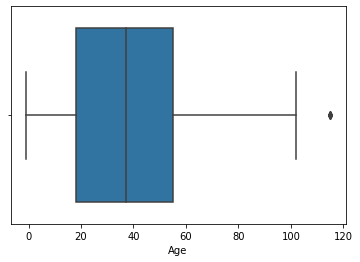

In [ ]:
# create a boxplot of the age using seaborn to select outliers of Age column
sns.boxplot(df.Age)
plt.show()

The boxplot confirms that there are outliers at the high end of the range. But the values below zero are not identified. To explore in more detailed vision:

In [ ]:
# return all entries less than 0 years old.
df[df.Age < 0]

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
AppointmentID,,,,,,,,,,,,,
5775010,4.659432e+14,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1,ROMÃO,0,0,0,0,0,0,No


In [ ]:

# return all entries older than 100
df[df.Age > 100]

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
AppointmentID,,,,,,,,,,,,,
5651757,9.762948e+14,F,2016-05-03T09:14:53Z,2016-05-03T00:00:00Z,102,CONQUISTA,0,0,0,0,0,0,No
5700278,3.196321e+13,F,2016-05-16T09:17:44Z,2016-05-19T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,Yes
5700279,3.196321e+13,F,2016-05-16T09:17:44Z,2016-05-19T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,Yes
5562812,3.196321e+13,F,2016-04-08T14:29:17Z,2016-05-16T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,Yes
5744037,3.196321e+13,F,2016-05-30T09:44:51Z,2016-05-30T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,No
5751563,2.342836e+11,F,2016-05-31T10:19:49Z,2016-06-02T00:00:00Z,102,MARIA ORTIZ,0,0,0,0,0,0,No
5717451,7.482346e+14,F,2016-05-19T07:57:56Z,2016-06-03T00:00:00Z,115,SÃO JOSÉ,0,1,0,0,0,1,No


There are also two patients reported to be 102. According to [wikipedia](https://en.wikipedia.org/wiki/List_of_living_centenarians), there are several people in Brazil in this age range. It is very possible that these entries are accurate and can be left in.

There are two patients who were allegedly 115 years old. According [Wikipedia](https://en.wikipedia.org/wiki/List_of_the_verified_oldest_people) are very rare. Removing these entries along with the -1 patient will ensure that they don't cause any outlier affects.

##**Data Cleaning**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


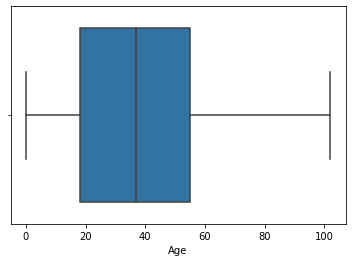

In [ ]:
# Trim the outliers
df = df[(df.Age > -1) & (df.Age < 115)]

# display the boxplot again to verify the outcome
sns.boxplot(df.Age)
plt.show()

The outliers are no longer present in the boxplot.

To make the dataset easy to work with some of the fields need to be converted to new data types. SheduledDay and AppointmentDay fields should be datetime objects, and the No-Show field will be easier to work with as a binary value.

In [ ]:
# Convert ScheduleDay and AppointmentDay to DateTime objects with pd.to_datetime
columns = ['ScheduledDay', 'AppointmentDay']
for column in columns:
    df[column] = pd.to_datetime(pd.to_datetime(df[column]).dt.date)

# drop the old No-show column
df.rename(columns={'No-show':'NoShow'}, inplace=True)

The day of week value can now be extracted from the AppointmentDay field to answer one of the questions.

A function can be created to pull the weekday_name property from Pandas datetime objects and populate a new field.

In [ ]:
# Create a function that takes a datetime (dt) and extracts the weekday_name property
day_from_datetime = lambda dt: dt.day_name()

# Apply the function to the AppointmentDay column
df['DayOfWeek'] = df.AppointmentDay.apply(day_from_datetime)

Then, counting the number of appointments for each DayOfWeek value.

In [ ]:
df.DayOfWeek.value_counts().to_frame(name='Number of Appointments')

,Number of Appointments
Wednesday,25867
Tuesday,25640
Monday,22712
Friday,19018
Thursday,17245
Saturday,39


Wednesday and Tuesday were the most common days for appointments, followed by Monday Friday and Thursday. Saturday was least common with only 39 appointments.

The last step of data cleaning will be to add a binary field for no shows. This will make calculating total and average numbers of no shows easier in analysis.

In [ ]:
# if the value Yes then change it to 0, otherwise 1
df.NoShow = np.where(df.NoShow == "Yes", 0, 1)
# confirm
df.NoShow.value_counts()

1    88205
0    22316
Name: NoShow, dtype: int64

Most patients weren't handicapped, 2042 with 1 handicap, 183 with 2 handicaps and so on. In my analysis I don't need to know how many handicaps a patient had, I just need to know if he was handicapped or not, so I will change these values to (0,1) only (0 not handicapped, 1 handicapped).

In [ ]:
# if the value is greater than 1 change it to 1, otherwise keep it
df['Handcap'] = np.where(df['Handcap'] > 1, 1, df['Handcap'])
# confirm
df.Handcap.value_counts()

0    108284
1      2237
Name: Handcap, dtype: int64

##**Exploratory Data Analysis**

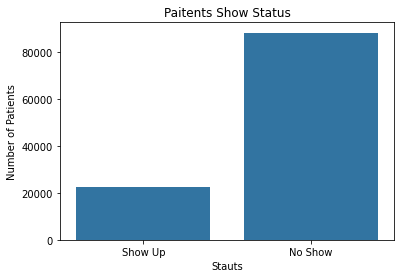

In [ ]:
# plot a bar chart
base_color = sns.color_palette()[0]
sns.countplot(data = df, x = 'NoShow', color = base_color)
plt.title('Paitents Show Status')
plt.xticks([0, 1], ['Show Up', 'No Show'])
plt.xlabel('Stauts')
plt.ylabel('Number of Patients');

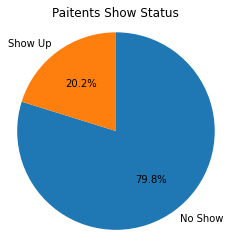

In [ ]:
"""
Plot the proportion of NoShows as a piechart.
Extra parameters are passed to ensure the pie chart is a square,
format the decimal and pop out the second slice for effect.
"""
sorted_counts = df.NoShow.value_counts()
plt.pie(sorted_counts, labels = ['No Show', 'Show Up'], startangle = 90,
        counterclock = False, autopct='%1.1f%%');
plt.axis('square')
plt.title('Paitents Show Status');

**gender column**

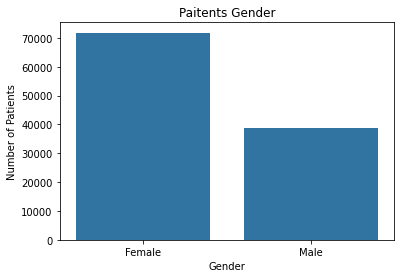

In [ ]:
# plot a bar chart
sns.countplot(data = df, x = 'Gender', color = base_color)
plt.title('Paitents Gender')
plt.xticks([0, 1], ['Female', 'Male'])
plt.xlabel('Gender')
plt.ylabel('Number of Patients');

It is easy to note that most patients were females.

**age column**


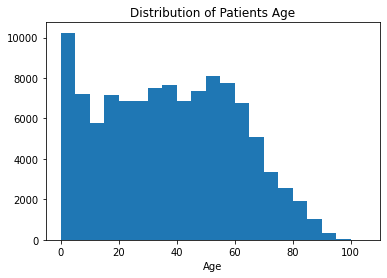

In [ ]:
# plot a histogram 
#bin_edges --> regers to bin's width
bin_edges = np.arange(0, df['Age'].max()+5, 5)
plt.hist(data = df, x = 'Age', bins = bin_edges)
plt.xlabel('Age')
plt.title('Distribution of Patients Age');

Most patients were young.

**scholarship column**

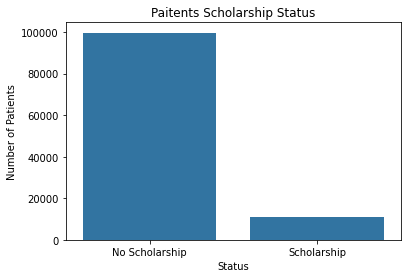

In [ ]:
# plot a bar chart
sns.countplot(data = df, x = 'Scholarship', color = base_color)
plt.title('Paitents Scholarship Status')
plt.xticks([0, 1], ['No Scholarship', 'Scholarship'])
plt.xlabel('Status')
plt.ylabel('Number of Patients');

Most patients didn't have a scholarship.

**alcoholism, diabetes, handcap, and hipertension columns**

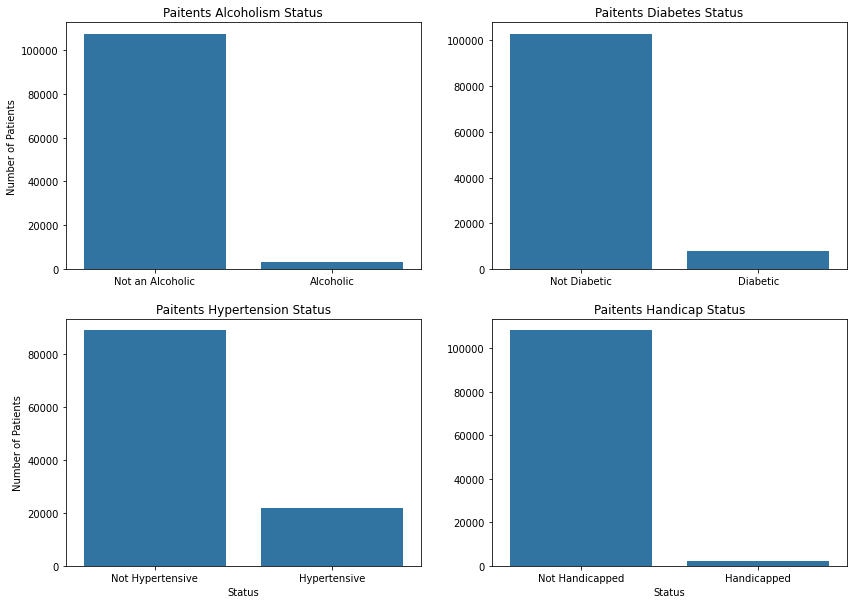

In [ ]:
plt.figure(figsize = [14, 10]) # larger figure size for subplots

# alcoholism column
plt.subplot(2, 2, 1) # 2 rows, 2 cols, subplot 1
sns.countplot(data = df, x = 'Alcoholism', color = base_color)
plt.title('Paitents Alcoholism Status')
plt.xticks([0, 1], ['Not an Alcoholic', 'Alcoholic'])
plt.xlabel('')
plt.ylabel('Number of Patients');

# diabetes column
plt.subplot(2, 2, 2) # 2 row, 2 cols, subplot 2
sns.countplot(data = df, x = 'Diabetes', color = base_color)
plt.title('Paitents Diabetes Status')
plt.xticks([0, 1], ['Not Diabetic', 'Diabetic'])
plt.xlabel('')
plt.ylabel('');

# hipertension column
plt.subplot(2, 2, 3) # 2 rows, 2 cols, subplot 3
sns.countplot(data = df, x = 'Hipertension', color = base_color)
plt.title('Paitents Hypertension Status')
plt.xticks([0, 1], ['Not Hypertensive', 'Hypertensive'])
plt.xlabel('Status')
plt.ylabel('Number of Patients');

# handcap column
plt.subplot(2, 2, 4) # 2 row, 2 cols, subplot 4
sns.countplot(data = df, x = 'Handcap', color = base_color)
plt.title('Paitents Handicap Status')
plt.xticks([0, 1], ['Not Handicapped','Handicapped'])
plt.xlabel('Status')
plt.ylabel('');

Most patients didn't suffer from alcoholism, diabetes, hypertension, or any handicap.

###**New Useful Columns**

In [ ]:
df.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,NoShow,DayOfWeek
AppointmentID,,,,,,,,,,,,,,
5642903,2.987250e+13,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,1,Friday
5642503,5.589978e+14,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,1,Friday
5642549,4.262962e+12,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,1,Friday
5642828,8.679512e+11,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1,Friday
5642494,8.841186e+12,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,1,Friday


***days_between (between scheduled_day and appointment_day)***

In [ ]:
# calculate days between scheduled_day and appointment_day
days_between = (df['AppointmentDay'] - df['ScheduledDay']).dt.days
# insert a new column (days_between) before column 3
df.insert(3, 'days_between', days_between)
df.head()

,PatientId,Gender,ScheduledDay,days_between,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,NoShow,DayOfWeek
AppointmentID,,,,,,,,,,,,,,,
5642903,2.987250e+13,F,2016-04-29,0,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,1,Friday
5642503,5.589978e+14,M,2016-04-29,0,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,1,Friday
5642549,4.262962e+12,F,2016-04-29,0,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,1,Friday
5642828,8.679512e+11,F,2016-04-29,0,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1,Friday
5642494,8.841186e+12,F,2016-04-29,0,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,1,Friday


In [ ]:
# make sure there are no negative values
negative_days = df.query('days_between < 0')
negative_days

,PatientId,Gender,ScheduledDay,days_between,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,NoShow,DayOfWeek
AppointmentID,,,,,,,,,,,,,,,
5679978,7.839273e+12,M,2016-05-10,-1,2016-05-09,38,RESISTÊNCIA,0,0,0,0,1,0,0,Monday
5715660,7.896294e+12,F,2016-05-18,-1,2016-05-17,19,SANTO ANTÔNIO,0,0,0,0,1,0,0,Tuesday
5664962,2.425226e+13,F,2016-05-05,-1,2016-05-04,22,CONSOLAÇÃO,0,0,0,0,0,0,0,Wednesday
5686628,9.982316e+14,F,2016-05-11,-6,2016-05-05,81,SANTO ANTÔNIO,0,0,0,0,0,0,0,Thursday
5655637,3.787482e+12,M,2016-05-04,-1,2016-05-03,7,TABUAZEIRO,0,0,0,0,0,0,0,Tuesday


Since it's not right to have a scheduled_day after appointment_day these rows will be droped.

In [ ]:
# drop the rows with negative days
df.drop(negative_days.index, inplace=True)
# check again
df.query('days_between < 0')

,PatientId,Gender,ScheduledDay,days_between,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,NoShow,DayOfWeek
AppointmentID,,,,,,,,,,,,,,,


***waiting period (classify days_between to 4 groups)***

In [ ]:
# view the min, 25%, 50%, 75%, max days_between values
df['days_between'].describe()

count    110516.000000
mean         10.184272
std          15.255201
min           0.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: days_between, dtype: float64

In [ ]:
# bin edges that will be used to "cut" the data into groups
bin_edges = [-1, 0, 4, 15, 179]
# labels for the four waiting period groups
bin_names = ['0 days','1-4 days','5-15 days','16 days and above']
waiting_period = pd.cut(df['days_between'], bin_edges, labels=bin_names)
waiting_period

AppointmentID
5642903               0 days
5642503               0 days
5642549               0 days
5642828               0 days
5642494               0 days
                 ...        
5651768    16 days and above
5650093    16 days and above
5630692    16 days and above
5630323    16 days and above
5629448    16 days and above
Name: days_between, Length: 110516, dtype: category
Categories (4, object): ['0 days' < '1-4 days' < '5-15 days' < '16 days and above']

In [ ]:
# insert a new column (waiting_period) before column 4
df.insert(4, 'waiting_period', waiting_period)
df.head()

,PatientId,Gender,ScheduledDay,days_between,waiting_period,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,NoShow,DayOfWeek
AppointmentID,,,,,,,,,,,,,,,,
5642903,2.987250e+13,F,2016-04-29,0,0 days,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,1,Friday
5642503,5.589978e+14,M,2016-04-29,0,0 days,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,1,Friday
5642549,4.262962e+12,F,2016-04-29,0,0 days,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,1,Friday
5642828,8.679512e+11,F,2016-04-29,0,0 days,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1,Friday
5642494,8.841186e+12,F,2016-04-29,0,0 days,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,1,Friday


Now, days_between column existance is not valuable

***age_group (classify age to 4 groups)***

In [ ]:
# view the min, 25%, 50%, 75%, max age values
df['Age'].describe()

count    110516.000000
mean         37.085861
std          23.104465
min           0.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         102.000000
Name: Age, dtype: float64

In [ ]:
# bin edges that will be used to "cut" the data into groups
bin_edges = [-1, 18, 37, 55, 115]
# labels for the four age groups
bin_names = ['0-18','19-37','38-55','56 and above']
age_group = pd.cut(df['Age'], bin_edges, labels=bin_names)
# insert a new column (age_group) before column 7
df.insert(7, 'age_group', age_group)
df.head()

,PatientId,Gender,ScheduledDay,days_between,waiting_period,AppointmentDay,Age,age_group,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,NoShow,DayOfWeek
AppointmentID,,,,,,,,,,,,,,,,,
5642903,2.987250e+13,F,2016-04-29,0,0 days,2016-04-29,62,56 and above,JARDIM DA PENHA,0,1,0,0,0,0,1,Friday
5642503,5.589978e+14,M,2016-04-29,0,0 days,2016-04-29,56,56 and above,JARDIM DA PENHA,0,0,0,0,0,0,1,Friday
5642549,4.262962e+12,F,2016-04-29,0,0 days,2016-04-29,62,56 and above,MATA DA PRAIA,0,0,0,0,0,0,1,Friday
5642828,8.679512e+11,F,2016-04-29,0,0 days,2016-04-29,8,0-18,PONTAL DE CAMBURI,0,0,0,0,0,0,1,Friday
5642494,8.841186e+12,F,2016-04-29,0,0 days,2016-04-29,56,56 and above,JARDIM DA PENHA,0,1,1,0,0,0,1,Friday


In [ ]:
# Drop columns that are no longer needed
df.drop(['ScheduledDay', 'AppointmentDay'], axis=1, inplace=True)
df.head()

,PatientId,Gender,days_between,waiting_period,Age,age_group,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,NoShow,DayOfWeek
AppointmentID,,,,,,,,,,,,,,,
5642903,2.987250e+13,F,0,0 days,62,56 and above,JARDIM DA PENHA,0,1,0,0,0,0,1,Friday
5642503,5.589978e+14,M,0,0 days,56,56 and above,JARDIM DA PENHA,0,0,0,0,0,0,1,Friday
5642549,4.262962e+12,F,0,0 days,62,56 and above,MATA DA PRAIA,0,0,0,0,0,0,1,Friday
5642828,8.679512e+11,F,0,0 days,8,0-18,PONTAL DE CAMBURI,0,0,0,0,0,0,1,Friday
5642494,8.841186e+12,F,0,0 days,56,56 and above,JARDIM DA PENHA,0,1,1,0,0,0,1,Friday


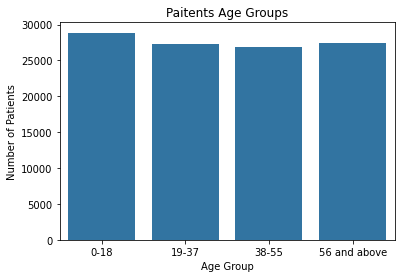

In [ ]:
# age_group column
# plot a bar chart
sns.countplot(data = df, x = 'age_group', color = base_color)
plt.title('Paitents Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Number of Patients');

Patients age groups were about the same, but the age group (0-18) being slightly higher.

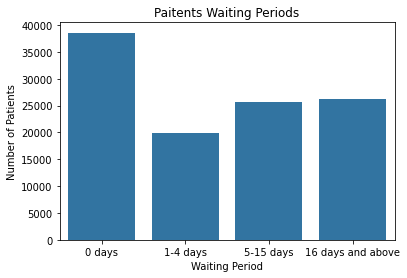

In [ ]:
# waiting_period column
# plot a bar chart
sns.countplot(data = df, x = 'waiting_period', color = base_color)
plt.title('Paitents Waiting Periods')
plt.xlabel('Waiting Period')
plt.ylabel('Number of Patients');

Most patients scheduled their appointments on the same day.

In [ ]:
DayOfWeek_counts = df.DayOfWeek.value_counts()
DayOfWeek_counts.index

Index(['Wednesday', 'Tuesday', 'Monday', 'Friday', 'Thursday', 'Saturday'], dtype='object')

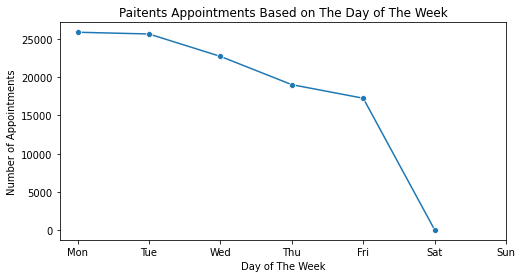

In [ ]:
# DayOfWeek column
DayOfWeek_counts = df.DayOfWeek.value_counts()
DayOfWeek_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# plot a line plot
plt.figure(figsize = [8, 4])
sns.lineplot(x = DayOfWeek_counts.index,  y = DayOfWeek_counts, marker='o')
plt.xticks(np.arange(0, 6+1, 1), DayOfWeek_labels)
plt.title('Paitents Appointments Based on The Day of The Week')
plt.xlabel('Day of The Week')
plt.ylabel('Number of Appointments');

Most patients prefered to have their appointments on days (Monday : Friday) especially Tuesday and Wednesday.

##**First question -->** Can the age be considered as a factor to predict if a patient will show up for their scheduled appointment?

This question can be answered in two methods:

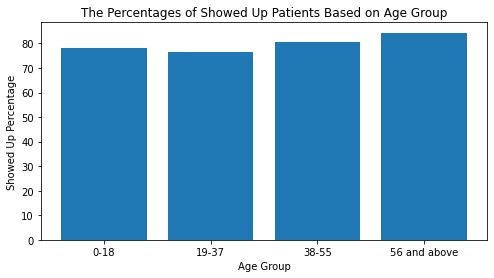

In [ ]:
# percentages of Showed Up patients based on age group
NoShow_perc_age = df.groupby('age_group').NoShow.mean() * 100

# plot a bar chart
plt.figure(figsize = [8, 4])
plt.bar(x = NoShow_perc_age.index, height = NoShow_perc_age)
plt.title('The Percentages of Showed Up Patients Based on Age Group')
plt.xlabel('Age Group')
plt.ylabel('Showed Up Percentage');

Patients age groups were about the same, with the age group (56 and above) being slightly higher.

the younger the patient is the more likely he/she is going to miss the appointment.


***2nd method -->***  Many of the variables to be tested in the research questions are categorical. This means that the chi-square test is appropriate for performing statistical testing.

In [ ]:
def chi_test(colA, colB):
    """
    Performs a chi-quare test between the values of two columns
    :param colA: First column of test
    :param colB: Second column of test
    """
    
    # The first step is to create a contingecy table tabulated from the distribution of the values
    contingency_table = pd.crosstab(colA, colB)

    # Display the table
    display(contingency_table)

    # use scipy to calculate the chi test statistic, p_value and degrees of freedom    
    chi2, p_value, dof, _ = stats.chi2_contingency(contingency_table, False)

    # Output a summary of the results
    print('The chi-square test returned a value of {:.2f} and was performed with {} degree(s) of freedom.'.format(chi2, dof))
    print('The p-value was {:.3f}'.format(p_value))

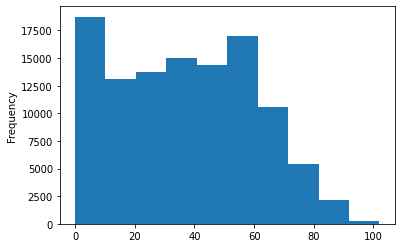

Mean age: 37.09


In [ ]:
df.Age.plot.hist()
plt.show()
# print the mean age for extra information
print('Mean age: {:.2f}'.format(df.Age.mean()))


The age of the full dataset has a bimodal distribution, with peaks around 0 and 60 years old. There is also a positive skew, which is expected because the minimal age is floored at 0 while the maximum age naturally tapers off.

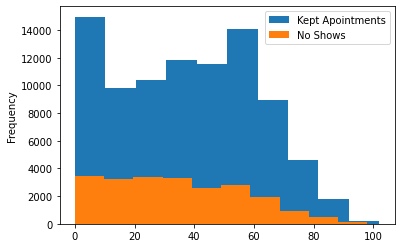

Kept Appointments Mean Age:37.79
Missed Appointments Mean Age:34.31


In [ ]:
kept = (df.NoShow == 1)
noshows = (df.NoShow == 0)

df[kept].Age.plot.hist()
df[noshows].Age.plot.hist()
plt.legend(['Kept Apointments', 'No Shows'])
plt.show()
print('Kept Appointments Mean Age:{:.2f}'.format(df[kept].Age.mean()))
print('Missed Appointments Mean Age:{:.2f}'.format(df[noshows].Age.mean()))

This histogram overlays the distributions of kept appointments and no shows so that they can be compared. The peak near 60 years is much smaller for no shows. The mean is also lower but is not apparent with a histogram. Box plots provide a better visualization for interpreting the difference in means.



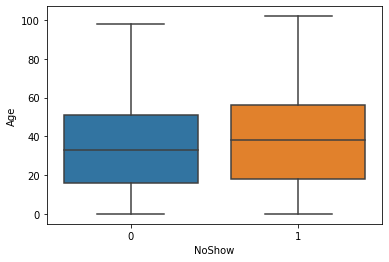

In [ ]:
# display a box plot of the age distribution for each No Show condition
sns.boxplot(x=df.NoShow, y=df.Age)
plt.show()

The average age and quartiles are slightly lower for NoShows. A T-test can be used to determine if the difference of the means is significant.



In [ ]:
# create filter for NoShows
noshows = (df.NoShow == 0)

# create pointers to the sample populations
noshow_ages = df[noshows].Age
show_ages = df[~noshows].Age

stat, p = stats.ttest_ind(noshow_ages, show_ages)
print(
    'The average age of noshows (M={:.2f}, SD={:.2f}) '.format(
        noshow_ages.mean(),
        noshow_ages.std())
    + 'was lower than kept appointments (M={:.2f}, SD={:.2f}) '.format(
        show_ages.mean(),
        show_ages.std())
    + 'by {:.2f} years.'.format(
        show_ages.mean() - noshow_ages.mean()
    )
)
print('The t-stastic was {:.2f} with a p-value of {:.3f}'.format(stat, p))

The average age of noshows (M=34.31, SD=21.95) was lower than kept appointments (M=37.79, SD=23.34) by 3.48 years.
The t-stastic was -20.15 with a p-value of 0.000


***Then, `The answer` --> The results show that there was a small but statistically significant difference in two methods.***

##***Question 2 --->*** Do SMS notifications coincide with fewer no shows?

In [ ]:
df.shape[0]

110516

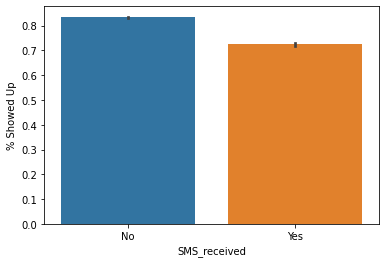

In [ ]:
# this dictionary will be used to map 1s and 0s to Yeses and Nos
yesno = {1:'Yes', 0:'No'}

# bar plot the percentage of noshows for each sms condition
ax = sns.barplot(x=df.SMS_received.map(yesno), y=df.NoShow)
ax.set_ylabel('% Showed Up')
plt.show()
showed_up_perc_sms = df.groupby('SMS_received').NoShow.mean() * 100

We can notice that percentage of showed up patients that received SMS is lower than non showed patients. It seems a little bit strange.

In [ ]:
# test the statistical significance with a chi-square test
chi_test(df.NoShow, df.SMS_received.map(yesno))
#0 ---> showed up
#1 ---> no show

SMS_received,No,Yes
NoShow,,
0,12527,9784
1,62508,25697


The chi-square test returned a value of 1769.97 and was performed with 1 degree(s) of freedom.
The p-value was 0.000


***Then, The chi-square test found the difference to be statistically significant.***

##**Question 3 --->*** Highest five neighbourhoods in terms of the number of no-show appointments?

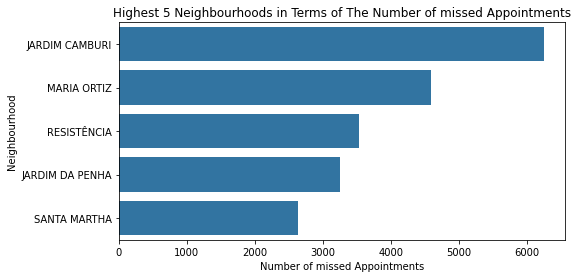

In [ ]:
# no show appointments
df_NoShow = df[df.NoShow == 1]

# plot a horizontal bar chart
plt.figure(figsize = [8, 4])
cat_order = df_NoShow['Neighbourhood'].value_counts().index[:5]
sns.countplot(data = df_NoShow, y = 'Neighbourhood', color = base_color, order = cat_order)
plt.title('Highest 5 Neighbourhoods in Terms of The Number of missed Appointments')
plt.xlabel('Number of missed Appointments')
plt.ylabel('Neighbourhood');

***As shown in the chart, JARDIM CAMBURI neighbourhood had the heighest number of missed appointments followed by MARIA ORTIZ.***

##***Question 4 --->*** Can the gender be considered as a factor to predict if a patient will show up for their scheduled appointment?

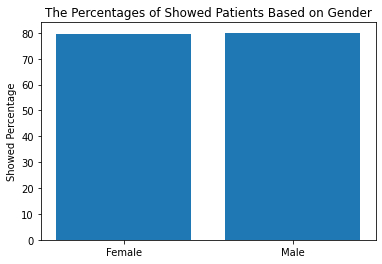

In [ ]:
# percentages of no show patients based on gender
no_show_perc_gender = df.groupby('Gender').NoShow.mean() * 100

# plot a bar chart
plt.bar(x = no_show_perc_gender.index, height = no_show_perc_gender)
plt.title('The Percentages of Showed Patients Based on Gender')
plt.xticks([0, 1], ['Female', 'Male'])
plt.ylabel('Showed Percentage');


Based on the chart, the percentages of no show patients based on gender were pretty close.

So, we can say that the gender can't be considered as a factor to predict if a patient will show up for their scheduled appointment.

##**question 5 --->** Can having a scholarship be considered as a factor to predict if a patient will show up for their scheduled appointment?

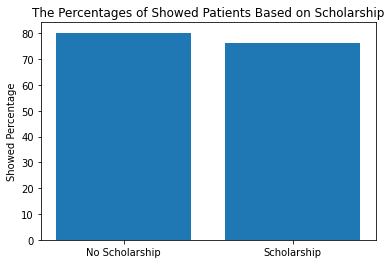

In [ ]:
# percentages of no show patients based on scholarship
no_show_perc_scholarship = df.groupby('Scholarship').NoShow.mean() * 100

# plot a bar chart
plt.bar(x = no_show_perc_scholarship.index, height = no_show_perc_scholarship)
plt.title('The Percentages of Showed Patients Based on Scholarship')
plt.xticks([0, 1], ['No Scholarship', 'Scholarship'])
plt.ylabel('Showed Percentage');

***It seems like the patient with a scholarship is more likely to miss the appointment.***
***So, we can say that having a scholarship could help us to predict if a patient will show up for their scheduled appointment.***

##**Question 6** ---> Can the waiting period between scheduled day and appointment day be considered as a factor to predict if a patient will show up for their scheduled appointment?

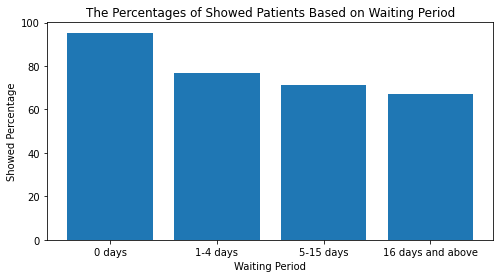

In [ ]:
# percentages of no show patients based on waiting period
no_show_perc_waiting_period = df.groupby('waiting_period').NoShow.mean() * 100

# plot a bar chart
plt.figure(figsize = [8, 4])
plt.bar(x = no_show_perc_waiting_period.index, height = no_show_perc_waiting_period)
plt.title('The Percentages of Showed Patients Based on Waiting Period')
plt.xlabel('Waiting Period')
plt.ylabel('Showed Percentage');

***It's pretty clear that the longer the waiting period is, the more likely the patient will not show up for the appointment.
So, we can say that the waiting period could help us to predict if a patient will show up for their scheduled appointment.***

##**Q7: What are the percentages of missed appointments for each special condition(alcoholism, diabetes ... etc) ?**

In [ ]:
# total number of special conditions for each patient
df['number_of_cond'] = df.Hipertension + df.Diabetes + df.Alcoholism + df.Handcap

# empty dictionary 
cond_dict = {}

# percentage of Showed patients who suffered from hypertension only
cond_dict['Hypertension'] = (df[df.number_of_cond <= 1].groupby('Hipertension').NoShow.mean() * 100)[1]
# percentage of Showed patients who suffered from diabetes only
cond_dict['Diabetes'] = (df[df.number_of_cond <= 1].groupby('Diabetes').NoShow.mean() * 100)[1]
# percentage of Showed patients who suffered from alcoholism only
cond_dict['Alcoholism'] = (df[df.number_of_cond <= 1].groupby('Alcoholism').NoShow.mean() * 100)[1]
# percentage of Showed patients who were handicapped only
cond_dict['Handicapped'] = (df[df.number_of_cond <= 1].groupby('Handcap').NoShow.mean() * 100)[1]

# percentage of Showed patients who suffered from multiple conditions
cond_dict['Multiple Conditions'] = df[df.number_of_cond > 1].NoShow.mean() * 100

cond_dict


{'Alcoholism': 78.35587929240374,
 'Diabetes': 79.64205816554811,
 'Handicapped': 80.68849706129303,
 'Hypertension': 82.98199385155907,
 'Multiple Conditions': 82.30184581976113}

In [ ]:
# convert the dictionary to a pandas series
cond_ser = pd.Series(cond_dict)
# sort the values in descending order
cond_ser.sort_values(ascending=False, inplace=True)
cond_ser

Hypertension           82.981994
Multiple Conditions    82.301846
Handicapped            80.688497
Diabetes               79.642058
Alcoholism             78.355879
dtype: float64

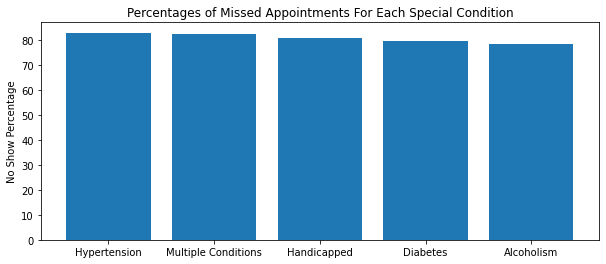

In [ ]:
# plot a bar chart
plt.figure(figsize = [10, 4])
plt.bar(x = cond_ser.index, height = cond_ser)
plt.title('Percentages of Missed Appointments For Each Special Condition')
plt.ylabel('No Show Percentage');

***we can say that alcoholics are the most likely to miss their appointments among other patients with special conditions.***

##**Question 8 --->** Do some days of the week have more no shows than others?

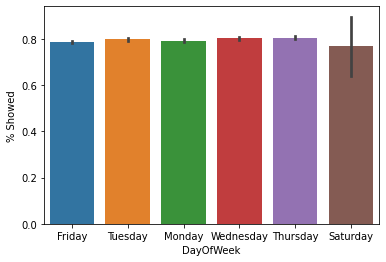

In [ ]:
# Ploot the average no shows for each day of the week.
ax = sns.barplot(x=df.DayOfWeek, y=df.NoShow)
ax.set(ylabel='% Showed')
plt.show()

***There appear to be higher incidences of no shows on Saturdays and Fridays. The error bar is also highest for Saturdays due to the extremely low incidence of Saturday apointments.***

In [ ]:
chi_test(df.NoShow, df.DayOfWeek)


DayOfWeek,Friday,Monday,Saturday,Thursday,Tuesday,Wednesday
NoShow,,,,,,
0,4037,4688,9,3335,5150,5092
1,14981,18023,30,13909,20488,20774


The chi-square test returned a value of 27.76 and was performed with 5 degree(s) of freedom.
The p-value was 0.000


***The chi-square test showed that the differences were statistically significant.***

##**Conclusions** 

In this project I analyzed Medical Appointment No Shows Dataset and communicated my findings about it using Python libraries NumPy, pandas, Matplotlib, and seaborn. The dataset contained 110,527 appointments in a period of 40 days, about 20% of the patients showed up for their appointments.

Most patients:

Were females.
Were young.
Didn't have a scholarship.
Didn't suffer from any special conditions (alcoholism, diabetes, hypertension, handicap).
Scheduled their appointments on the same day.
Prefered to have their appointments on working days (Monday-Friday) especially Tuesday and Wednesday.

##**Limitations**

* The dataset covers a short period 40 days only, longer period could lead to a better results.
* Appointment time wasn't given, which could be very useful.
* Dataset description on kaggle wasn't up to date, so some columns values weren't clear until found in disscussion forms.
* Recent data would be much better, since 2016 is about 4 years ago and a lot has changed since then.
* Covering more than one country would've been better.

##**References**

[Graph Plotting in Python](https://www.geeksforgeeks.org/graph-plotting-in-python-set-1/)

[seaborn plotting functions](https://seaborn.pydata.org/tutorial/function_overview.html)

https://shawnemhe.github.io/udacity-data-analyst//p2/Investigate_a_Dataset.html#wrangling

[pandas documentation](https://pandas.pydata.org/pandas-docs/stable/index.html)